In [1]:
import pandas as pd
import scipy.io
import scipy.sparse as sp
import anndata as ad
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# https://singlecell.broadinstitute.org/single_cell/study/SCP1852/integrated-multiomic-characterization-of-congenital-heart-disease#study-visualize


# --- File paths ---
in_path = "../data/scRNA_CHD/"
mtx_file       = in_path + "AllNuclei_snRNA_counts.mtx"
rownames_file  = in_path + "AllNuclei_snRNA_counts_rownames.txt"
colnames_file  = in_path + "AllNuclei_snRNA_counts_colnames.txt"
metadata_file  = in_path + "AllNuclei_snRNA_metadata.csv"

# --- Load count matrix ---
print("Loading count matrix...")
X = scipy.io.mmread(mtx_file).tocsr()  # cells x genes (or genes x cells depending on format)

# --- Load feature (gene) names ---
print("Loading row names...")
var_names = pd.read_csv(rownames_file, header=None, sep="\t")[0].astype(str).values

# --- Load cell/sample names ---
print("Loading column names...")
obs_names = pd.read_csv(colnames_file, header=None, sep="\t")[0].astype(str).values

# --- Ensure correct orientation ---
# MatrixMarket usually stores as (genes x cells). 
# We want AnnData with shape (n_obs = cells, n_vars = genes).
if X.shape[0] == len(var_names) and X.shape[1] == len(obs_names):
    # already genes x cells → transpose to cells x genes
    X = X.T
elif X.shape[0] == len(obs_names) and X.shape[1] == len(var_names):
    pass  # already cells x genes
else:
    raise ValueError("Dimension mismatch: check row/col order of .mtx and name files.")

# --- Load metadata ---
print("Loading metadata...")
obs = pd.read_csv(metadata_file, index_col=0)
# Make sure metadata index matches obs_names
obs.index = obs.index.astype(str)
obs = obs.reindex(obs_names)  # align to colnames order

# --- Build AnnData ---
print("Building AnnData object...")
adata = ad.AnnData(
    X=X,
    obs=obs,
    var=pd.DataFrame(index=var_names)
)

# Fill index names
adata.obs_names = obs_names
adata.var_names = var_names

print(adata)


Loading count matrix...
Loading row names...
Loading column names...
Loading metadata...
Building AnnData object...
AnnData object with n_obs × n_vars = 157293 × 29266
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'labID', 'procedure', 'age', 'gender', 'echoEF', 'vers10X', 'diagnosis', 'ageCont', 'region', 'batch_indices', 'percent_mt', 'ClinicalRank', 'DEid', 'MainCellType', 'Cluster', 'labID2', 'colors', 'Diagnosis', 'patientID', 'cell_id', 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'sex', 'library_preparation_protocol__ontology_label'


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_17832/1353753558.py:36: DtypeWarning: Columns (2,3,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  obs = pd.read_csv(metadata_file, index_col=0)


In [3]:
adata.obs.columns

Index(['orig_ident', 'nCount_RNA', 'nFeature_RNA', 'labID', 'procedure', 'age',
       'gender', 'echoEF', 'vers10X', 'diagnosis', 'ageCont', 'region',
       'batch_indices', 'percent_mt', 'ClinicalRank', 'DEid', 'MainCellType',
       'Cluster', 'labID2', 'colors', 'Diagnosis', 'patientID', 'cell_id',
       'biosample_id', 'donor_id', 'species', 'species__ontology_label',
       'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label',
       'library_preparation_protocol', 'sex',
       'library_preparation_protocol__ontology_label'],
      dtype='object')

In [4]:
Counter(adata.obs.diagnosis)

Counter({'HLHS': 21050,
         'HTx': 38171,
         'TOF': 15836,
         'LVAD': 27976,
         'Donor': 54260})

In [5]:
Counter(adata.obs.Diagnosis)

Counter({'Neo_HLHS': 6995,
         'HF_HLHS': 30376,
         'TOF': 15836,
         'DCM': 27976,
         'HCM': 21850,
         'Donor': 54260})

In [6]:
Counter(adata.obs.MainCellType)

Counter({'CM': 73296,
         'Neurons': 1985,
         'Adipo': 454,
         'EpiC': 41,
         'Mac': 7010,
         'Tcells': 1121,
         'Mast': 92,
         'Endo': 35673,
         'ENDOC': 1436,
         'LEC': 658,
         'PeriC': 12037,
         'SMC': 2405,
         'EpiL': 51,
         'CF': 21034})

In [7]:
Counter(adata.obs.patientID)

Counter({'P8': 6995,
         'P40': 16321,
         'P26': 2428,
         'P33': 7213,
         'P36': 12906,
         'P64': 14055,
         'P75': 15070,
         'P86': 21850,
         '13_198_LV': 13133,
         'P28': 6195,
         '13_198_RV': 12721,
         '13_235': 11012,
         'UK1': 5158,
         'UK2': 12236})

In [8]:
# Donor = control (baseline, non-diseased human heart)
# HLHS, = Hypoplastic Left Heart Syndrome - congenital defects
# TOF — Tetralogy of Fallot - Another congenital heart defect.
# LVAD — Left Ventricular Assist Device - A mechanical pump surgically implanted in patients with end-stage heart failure.
# HTx = severe acquired heart failure + interventions
for diag in adata.obs.Diagnosis.unique():
    print(diag, adata.obs[adata.obs.Diagnosis == diag]['patientID'].unique())
print('-' * 54)
for diag in adata.obs.diagnosis.unique():
    print(diag, adata.obs[adata.obs.diagnosis == diag]['patientID'].unique())

Neo_HLHS ['P8']
HF_HLHS ['P40' 'P64']
TOF ['P26' 'P33' 'P28']
DCM ['P36' 'P75']
HCM ['P86']
Donor ['13_198_LV' '13_198_RV' '13_235' 'UK1' 'UK2']
------------------------------------------------------
HLHS ['P8' 'P64']
HTx ['P40' 'P86']
TOF ['P26' 'P33' 'P28']
LVAD ['P36' 'P75']
Donor ['13_198_LV' '13_198_RV' '13_235' 'UK1' 'UK2']


# Graph construction

In [9]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.covariance import EmpiricalCovariance

top_n_genes=2000
# def construct_adj_matrix(adata, top_n_genes=2000, subtype_file="../data/scRNA_CHD/subtype_spec_genes.csv"):
print("📌 Starting adjacency matrix construction...")

# --- Copy AnnData to avoid modifying original ---
print("➡️ Copying AnnData object...")
ad = adata.copy()

# --- Gene filtering ---
print("➡️ Filtering genes with min_cells=10...")
sc.pp.filter_genes(ad, min_cells=10)
print(f"Remaining genes after filtering: {ad.n_vars}")

# --- Normalize ---
print("➡️ Normalizing total counts per cell (target_sum=1e4)...")
sc.pp.normalize_total(ad, target_sum=1e4)

# --- Log transform ---
print("➡️ Applying log1p transform...")
sc.pp.log1p(ad)

# --- Convert to DataFrame ---
print("➡️ Converting to dense DataFrame (may use large memory)...")
expr = pd.DataFrame(
    ad.X.toarray() if hasattr(ad.X, "toarray") else ad.X,
    index=ad.obs_names,
    columns=ad.var_names
)
print(f"Expression matrix shape: {expr.shape}")



📌 Starting adjacency matrix construction...
➡️ Copying AnnData object...
➡️ Filtering genes with min_cells=10...
Remaining genes after filtering: 27279
➡️ Normalizing total counts per cell (target_sum=1e4)...
➡️ Applying log1p transform...
➡️ Converting to dense DataFrame (may use large memory)...
Expression matrix shape: (157293, 27279)
➡️ Loaded 947 subtype-specific genes present in dataset.


In [53]:
# --- Load subtype-specific genes --- https://chddb.fwgenetics.org/browse
chd_genes_df_file="../data/scRNA_CHD/subtype_spec_genes.csv"
chd_genes_df = pd.read_csv(chd_genes_df_file)
chd_genes_df = chd_genes_df[chd_genes_df['Species'] == 'Human']
chd_genes_avail_df = chd_genes_df[chd_genes_df['Gene'].isin(expr.columns)]
print(f"➡️ Loaded {len(chd_genes_avail_df)} subtype-specific human genes present in dataset out of {len(chd_genes_df)}.")
# subtype_genes_df = subtype_genes_df[subtype_genes_df['Associated CHD'].str.contains('TOF')]
chd_genes = set(chd_genes_avail_df['Gene'].astype(str).tolist())
chd_genes_avail_df.to_csv(chd_genes_df_file.replace('.csv', '_available.csv'), index=False)

➡️ Loaded 2995 subtype-specific human genes present in dataset out of 3218.


In [50]:
chd_genes_avail_df['Associated CHD'].unique()

array(['TOF', 'TGA; PS; HLHS; CoA', 'CHD', 'Septal defects',
       'VSD; TGA; PA; ASD', 'VSD; PDA; CoA; ASD', 'PS; HLHS', 'VSD; TOF',
       'Isomerism; APVC', 'PDA; IAA; CoA', 'ASD',
       'VSD; PS; MVS; MR; EA; ASD', 'PDA', 'VSD; ASD', 'LSLs',
       'VSD; Right ventricular hypoplasia; PS',
       'TOF; Malformation of the outflow tracts', 'TOF; RAA',
       'VSD; TGA; CHD; ASD', 'SV', 'PS',
       'TR; PS; MR; Dysplasia of aortic valve; Congenital pulmonary regurgitation; BAV; AR',
       'PS; Congenital pulmonary regurgitation; Congenital anomaly of pulmonary valve; Congenital anomaly of aortic valve; BAV; AS; AR',
       'VSD; PS; PDA; ASD', 'VSD; PDA; ASD', 'VSD',
       'VSD; Vena cava abnormality; Right ventricular hypoplasia; Malformation of the outflow tracts; Congenital arterial duct anomaly',
       'MVS', 'VSD; PS; DORV; ASD', 'VSD; PDA', 'VSD; POF; PDA',
       'PDA; Isomerism', 'PTA; ASD', 'CTD', 'BAV', 'PDA; CoA; BAV',
       'PDA; AR', 'LVOTO; CTD', 'VSD; PA', 'VSD; 

In [51]:
gene_variances.index

Index(['RP11-34P13.7', 'AL627309.1', 'AP006222.2', 'RP4-669L17.10',
       'RP5-857K21.2', 'RP5-857K21.4', 'RP11-206L10.3', 'RP11-206L10.5',
       'RP11-206L10.4', 'RP11-206L10.2',
       ...
       'TCF23', 'RP1-74M1.3', 'C3orf80', 'AC073115.7', 'SIGLEC5', 'AC114788.2',
       'RP5-1104E15.6', 'RP11-94B19.7', 'TRERNA1', 'AC093627.7'],
      dtype='object', length=27279)

In [52]:
# https://www.pnas.org/doi/10.1073/pnas.2420343122#supplementary-materials, Table S7
genes_60_df = pd.read_excel('../data/scRNA_CHD/pnas.2420343122.sd07.xlsx', header=6)
genes_60 = genes_60_df[genes_60_df['Sig 60'] == 'T'][['Name']]
genes_60_available = list(filter(lambda x: x in adata.var.index, genes_60['Name'].values))  # use all
pd.DataFrame(genes_60_available, columns=['x']).to_csv('../data/scRNA_CHD/genes_60.csv', index=False)


len(genes_60_available)

59

In [45]:
# --- Variance-based HVG selection ---
print("➡️ Selecting HVGs to fill up to", top_n_genes)
gene_variances = expr.var(axis=0)
chd_genes_available = list(set(chd_genes).union(set(genes_60_available)))  # use all

# Drop already included subtype genes from ranking
ranked_genes = gene_variances.drop(chd_genes_available, errors="ignore").nlargest(
    max(0, top_n_genes - len(chd_genes_available))
).index.tolist()

# Final gene list = subtype genes + top remaining HVGs
selected_genes = list(dict.fromkeys(chd_genes_available + ranked_genes))  # keep order, avoid duplicates

expr_hvg = expr[selected_genes]
print(f"Selected HVG matrix shape: {expr_hvg.shape}")
    
for subgroup in ["HLHS", "TOF"]:
    subgroup_genes_df = chd_genes_df[chd_genes_df['Associated CHD'].str.contains(subgroup)]
    subgroup_genes = subgroup_genes_df['Gene'].astype(str).tolist()
    subgroup_genes = list(set(subgroup_genes).intersection(set(chd_genes_available)))
    
    print(f"➡️ Final selected gene count: {len(chd_genes)} (Subtype={len(subgroup_genes)}, HVGs={len(ranked_genes)})")

    # --- Split into groups ---
    print("➡️ Splitting into groups (case+control vs control)...")
    #  HLHS (Hypoplastic Left Heart Syndrome) and TOF (Tetralogy of Fallot) are specific, severe types of CHD
    mask_case_ctrl = ad.obs["diagnosis"].isin(["Donor", subgroup]) 
    mask_ctrl = ad.obs["diagnosis"] == "Donor"

    case_ctrl_df = expr_hvg.loc[mask_case_ctrl].T  # genes × cells
    ctrl_df = expr_hvg.loc[mask_ctrl].T            # genes × cells
    expr_hvg_T = expr_hvg.T                        # genes × all cells
    print(f"Case+Control shape: {case_ctrl_df.shape}, Control shape: {ctrl_df.shape}")

    # --- Safe inverse covariance helper ---
    def safe_inverse_cov(X):
        print("   ⏳ Computing covariance...")
        cov = np.cov(X, bias=False)
        print("   ⏳ Inverting covariance matrix...")
        try:
            return np.linalg.inv(cov)
        except np.linalg.LinAlgError:
            print("   ⚠️ Singular covariance, using EmpiricalCovariance...")
            cov_estimator = EmpiricalCovariance().fit(X.T)
            return cov_estimator.precision_

    # --- Compute precision matrices ---
    print("➡️ Computing inverse covariance (case+control)...")
    inv_case_ctrl = safe_inverse_cov(case_ctrl_df)

    print("➡️ Computing inverse covariance (control)...")
    inv_ctrl = safe_inverse_cov(ctrl_df)

    # --- Compute difference matrix ---
    print("➡️ Computing symmetric absolute difference matrix...")
    diff = np.abs(inv_case_ctrl - inv_ctrl)
    diff_df = pd.DataFrame(
        np.maximum(diff, diff.T),
        index=expr_hvg_T.index,
        columns=expr_hvg_T.index
    )
    print(f"{subgroup} genes: {len(subgroup_genes)}")
    print("✅ Finished! Adjacency matrix shape:", diff_df.shape)
    # return diff_df


    # diff_df = construct_adj_matrix(adata, top_n_genes=2000)
    print(diff_df.shape)

    # extract upper triangle (excluding diagonal) for threshold calculation
    values = diff_df.values[np.triu_indices_from(diff_df, k=1)]

    # threshold for top 5%
    threshold = np.percentile(values, 99)

    # keep only edges above threshold
    filtered_df = diff_df.where(diff_df >= threshold, 0)

    # set diagonal to 0 explicitly
    np.fill_diagonal(filtered_df.values, 0)

    # Save files
    filtered_df.to_csv(f'../data/scRNA_CHD/adj_{subgroup}.csv', index=False)
    pd.DataFrame(subgroup_genes, columns=['x']).to_csv(f'../data/scRNA_CHD/genes_{subgroup}.csv', index=False)

➡️ Selecting HVGs to fill up to 2000
Selected HVG matrix shape: (157293, 2000)
➡️ Final selected gene count: 947 (Subtype=119, HVGs=1001)
➡️ Splitting into groups (case+control vs control)...
Case+Control shape: (2000, 75310), Control shape: (2000, 54260)
➡️ Computing inverse covariance (case+control)...
   ⏳ Computing covariance...
   ⏳ Inverting covariance matrix...
➡️ Computing inverse covariance (control)...
   ⏳ Computing covariance...
   ⏳ Inverting covariance matrix...
➡️ Computing symmetric absolute difference matrix...
HLHS genes: 119
✅ Finished! Adjacency matrix shape: (2000, 2000)
(2000, 2000)
➡️ Final selected gene count: 947 (Subtype=366, HVGs=1001)
➡️ Splitting into groups (case+control vs control)...
Case+Control shape: (2000, 70096), Control shape: (2000, 54260)
➡️ Computing inverse covariance (case+control)...
   ⏳ Computing covariance...
   ⏳ Inverting covariance matrix...
➡️ Computing inverse covariance (control)...
   ⏳ Computing covariance...
   ⏳ Inverting covaria

In [46]:
tof = pd.read_csv('../data/scRNA_CHD/adj_TOF.csv')

In [54]:
len(set(genes_60_available).difference(set(tof.columns)))

0

In [4]:
filtered_df = pd.read_csv('../data/scRNA_CHD/adj.csv')
filtered_df

,NOTCH3,TCN2,SOX18,MAP7D1,TP53BP2,GATA5,COL6A2,CA3,HEY2,FGF2,...,SNRNP70,DIAPH1,XRN1,WDR70,TRPC4AP,AMBRA1,CDC42SE2,TFCP2,RAB2A,WHSC1L1
0,0.000000,0.000000,0.513021,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.984945,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.513021,0.984945,0.000000,0.0,0.773364,1.806696,0.0,0.502676,0.0,0.0,...,0.479614,0.0,0.537453,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.773364,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
len(subtype_genes)

366

In [9]:
import pandas as pd

# Load file
df = pd.read_csv("../data/chd/edge_weights_chd.csv")

# Use 'source' and 'target' as nodes, weight as values
adj = df.pivot_table(index="source",
                     columns="target",
                     values="weight",
                     fill_value=0)

# Save adjacency matrix
adj.to_csv("../data/chd/adj_UBKG_chd.csv")


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_89424/1186048343.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/chd/edge_weights_chd.csv")


In [10]:
adj

target,AZ:0000002 CUI,AZ:0000003 CUI,AZ:0000010 CUI,AZ:0000011 CUI,AZ:0000014 CUI,AZ:0000022 CUI,AZ:0000024 CUI,AZ:0000033 CUI,AZ:0000034 CUI,AZ:0000038 CUI,...,WP:WP5344 CUI,WP:WP5346 CUI,WP:WP5356 CUI,WP:WP5358 CUI,WP:WP5365 CUI,WP:WP5399 CUI,WP:WP5400 CUI,WP:WP581 CUI,WP:WP706 CUI,WP:WP722 CUI
source,,,,,,,,,,,,,,,,,,,,,
C0085113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C0152021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C0242987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C0242988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C0808901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2681526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2681656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2828748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
diff_df = pd.read_csv('../data/scRNA_CHD/adj.csv')

In [21]:
import pandas as pd
import networkx as nx
import numpy as np
from pyvis.network import Network

# --- Input ---
# diff_df = your adjacency matrix DataFrame (symmetric, nodes as index & columns)
# Example subset of nodes
subset_nodes = {"GeneA", "GeneB", "GeneC"}

# --- Step 1: Extract top 10,000 strongest edges ---
# Flatten upper triangle (excluding self-loops)
edges = []
nodes = diff_df.index.to_list()

for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        weight = diff_df.iat[i, j]
        if weight != 0:
            edges.append((nodes[i], nodes[j], weight))

# Sort by absolute weight and take top 10,000
edges = sorted(edges, key=lambda x: abs(x[2]), reverse=True)[:10000]

print(f"Selected {len(edges)} strongest edges out of ~{diff_df.size/2:.0f}")

# --- Step 2: Build graph ---
G = nx.Graph()
G.add_weighted_edges_from(edges)

# --- Step 3: Visualize with PyVis ---
net = Network(height="900px", width="100%", bgcolor="white", font_color="black", notebook=True)
net.barnes_hut(gravity=-20000, central_gravity=0.3, spring_length=150, spring_strength=0.001, damping=0.9)

for node in G.nodes():
    if node in subset_nodes:
        net.add_node(node, color="red", size=15)
    else:
        net.add_node(node, color="blue", size=8)

for u, v, w in G.edges(data="weight"):
    net.add_edge(u, v, value=abs(w))

net.show("graph.html")


Selected 10000 strongest edges out of ~2000000
graph.html


📌 Building graph from adjacency matrix...
⚠️ Graph too dense: 871866 edges. Keeping top 40000.
📊 Graph Statistics:
   Nodes: 2000
   Edges: 20000
   Avg degree: 20.00
   Max degree: 1536
   Connected components: 1


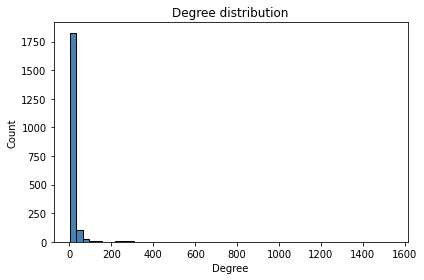

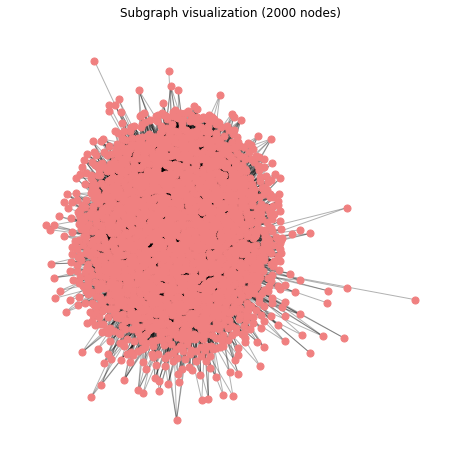

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def graph_stats_and_visualize(adj_df, edge_threshold=0.05, max_edges=5000, subgraph_size=200):
    """
    Build a graph from an adjacency matrix and show statistics + visualizations.

    Parameters
    ----------
    adj_df : pd.DataFrame
        Symmetric adjacency matrix (genes × genes).
    edge_threshold : float
        Minimum edge weight to keep in graph.
    max_edges : int
        Maximum number of edges kept (for speed).
    subgraph_size : int
        Number of nodes to randomly sample for visualization.
    """

    print("📌 Building graph from adjacency matrix...")

    # --- Convert adjacency to graph ---
    A = adj_df.values.copy()
    np.fill_diagonal(A, 0)  # remove self-loops
    edges = np.where(A > edge_threshold)

    G = nx.Graph()
    G.add_nodes_from(adj_df.index)

    # Add edges with weights
    edge_list = list(zip(adj_df.index[edges[0]], adj_df.index[edges[1]], A[edges]))
    if len(edge_list) > max_edges:
        print(f"⚠️ Graph too dense: {len(edge_list)} edges. Keeping top {max_edges}.")
        edge_list = sorted(edge_list, key=lambda x: x[2], reverse=True)[:max_edges]
    G.add_weighted_edges_from(edge_list)

    # --- Graph statistics ---
    degrees = dict(G.degree())
    print("📊 Graph Statistics:")
    print(f"   Nodes: {G.number_of_nodes()}")
    print(f"   Edges: {G.number_of_edges()}")
    print(f"   Avg degree: {np.mean(list(degrees.values())):.2f}")
    print(f"   Max degree: {np.max(list(degrees.values()))}")
    print(f"   Connected components: {nx.number_connected_components(G)}")

    # --- Degree distribution ---
    plt.figure(figsize=(6,4))
    plt.hist(list(degrees.values()), bins=50, color="steelblue", edgecolor="k")
    plt.title("Degree distribution")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # --- Graph visualization (subgraph) ---
    if subgraph_size < len(G):
        sub_nodes = np.random.choice(G.nodes, size=subgraph_size, replace=False)
        H = G.subgraph(sub_nodes)
    else:
        H = G

    plt.figure(figsize=(8,8))
    pos = nx.kamada_kawai_layout(H)#, seed=42)
    nx.draw_networkx_nodes(H, pos, node_size=50, node_color="lightcoral")
    nx.draw_networkx_edges(H, pos, alpha=0.3)
    plt.title(f"Subgraph visualization ({len(H)} nodes)")
    plt.axis("off")
    plt.show()

    return G

G = graph_stats_and_visualize(diff_df, edge_threshold=0.05, max_edges=40000, subgraph_size=2000)

📌 Building graph from adjacency matrix...
⚠️ Graph too dense: 346458 edges. Keeping top 10000.
📊 Graph Statistics:
   Nodes: 2000
   Edges: 5000
   Avg degree: 5.00
   Max degree: 928
   Connected components: 404


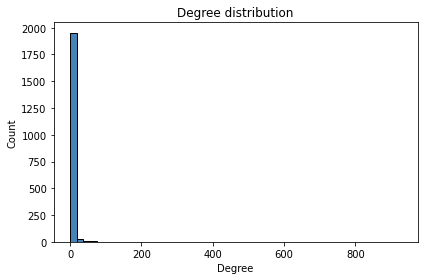

➡️ Visualizing subgraph with 1000 nodes and 699 edges


ArpackNoConvergence: ARPACK error -1: No convergence (10001 iterations, 9/11 eigenvectors converged)

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap.umap_ as umap

def graph_stats_and_visualize(adj_df, edge_threshold=0.05, max_edges=5000, subgraph_size=200, use_umap=True):
    """
    Build a graph from an adjacency matrix and show statistics + visualizations.
    Optimized to avoid memory crashes on ~2000 nodes.
    """

    print("📌 Building graph from adjacency matrix...")

    # --- Convert adjacency to graph (sparse) ---
    A = adj_df.values.copy()
    np.fill_diagonal(A, 0)  # remove self-loops
    edges = np.where(A > edge_threshold)

    G = nx.Graph()
    G.add_nodes_from(adj_df.index)

    # Add edges with weights
    edge_list = list(zip(adj_df.index[edges[0]], adj_df.index[edges[1]], A[edges]))
    if len(edge_list) > max_edges:
        print(f"⚠️ Graph too dense: {len(edge_list)} edges. Keeping top {max_edges}.")
        edge_list = sorted(edge_list, key=lambda x: x[2], reverse=True)[:max_edges]
    G.add_weighted_edges_from(edge_list)

    # --- Graph statistics ---
    degrees = dict(G.degree())
    print("📊 Graph Statistics:")
    print(f"   Nodes: {G.number_of_nodes()}")
    print(f"   Edges: {G.number_of_edges()}")
    print(f"   Avg degree: {np.mean(list(degrees.values())):.2f}")
    print(f"   Max degree: {np.max(list(degrees.values()))}")
    print(f"   Connected components: {nx.number_connected_components(G)}")

    # --- Degree distribution ---
    plt.figure(figsize=(6,4))
    plt.hist(list(degrees.values()), bins=50, color="steelblue", edgecolor="k")
    plt.title("Degree distribution")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # --- Subgraph for visualization ---
    if subgraph_size < len(G):
        sub_nodes = np.random.choice(list(G.nodes), size=subgraph_size, replace=False)
        H = G.subgraph(sub_nodes).copy()
    else:
        H = G.copy()

    print(f"➡️ Visualizing subgraph with {len(H)} nodes and {H.number_of_edges()} edges")

    # --- Lightweight spectral layout ---
    pos_spec = nx.spectral_layout(H, dim=10)  # 10D embedding from Laplacian
    coords = np.array([pos_spec[n] for n in H.nodes()])

    if use_umap:
        print("➡️ Running UMAP on spectral coords...")
        reducer = umap.UMAP(n_components=2, random_state=42)
        coords_2d = reducer.fit_transform(coords)
    else:
        coords_2d = coords[:, :2]

    # --- Visualization ---
    plt.figure(figsize=(8,8))
    nx.draw_networkx_nodes(H, pos={n: coords_2d[i] for i, n in enumerate(H.nodes())},
                           node_size=30, node_color="lightcoral", alpha=0.8)
    nx.draw_networkx_edges(H, pos={n: coords_2d[i] for i, n in enumerate(H.nodes())},
                           alpha=0.05, width=0.5)
    plt.title(f"Graph embedding visualization ({len(H)} nodes)")
    plt.axis("off")
    plt.show()

    return G

# Example run
G = graph_stats_and_visualize(diff_df, edge_threshold=0.1, max_edges=10000, subgraph_size=1000)


# Stats

In [30]:
import json
import pandas as pd
with open("../data/scRNA_CHD/chd.json", "r") as f:
    ctd_json = json.load(f)
s_nodes = ctd_json['S_perturbed_nodes']
f_nodes = ctd_json['F_most_connected_nodes']
gba_nodes = pd.read_csv('../data/scRNA_CHD/chd_ctd_selected_0.824_gba_ranks.csv')

In [35]:
top_gba_nodes = gba_nodes['Node_id'][:(len(s_nodes) - len(f_nodes))].values
len(top_gba_nodes)

273

In [37]:
len(set(top_gba_nodes).intersection(s_nodes))

58

In [57]:
#!/usr/bin/env python3
"""
Pipeline Script for CTD + GBA Analysis
--------------------------------------

This script automates the workflow:
1. Run CTD.py with adjacency matrix + s_module input.
2. Extract F_most_connected_nodes → save as one-column CSV.
3. Run main_gba.py with adj_matrix + generated F_most_connected_nodes CSV.
4. Process resulting *_gba_ranks.csv file:
   - Take top (len(S_nodes) - len(F_nodes)) Node_id entries.
   - Report intersection size with original S_nodes.

Usage:
    python run_pipeline.py --adj_matrix path/to/adj.csv --s_module path/to/s_module.csv
"""

import argparse
import json
import os
import subprocess
import pandas as pd
import glob

# ═══════════════════════════════════════════════════════════════
# 1. Parse arguments
# ═══════════════════════════════════════════════════════════════
def parse_args():
    parser = argparse.ArgumentParser(description="CTD + GBA automated pipeline")
    parser.add_argument("--adj_matrix", required=True, help="Adjacency matrix CSV file")
    parser.add_argument("--s_module", required=True, help="Single-column CSV file with nodes")
    return parser.parse_args()


# ═══════════════════════════════════════════════════════════════
# 2. Run CTD.py and generate JSON output
# ═══════════════════════════════════════════════════════════════
def run_ctd(adj_matrix, s_module):
    """
    Calls CTD.py tool with the provided adjacency matrix and s_module.
    Returns parsed JSON as dictionary.
    """
    json_output_file = s_module.replace('.csv', '.json')#"ctd_output.json"

    subprocess.run([
        "python", "../CTD.py",
        "--adj_matrix", adj_matrix,
        "--s_module", s_module,
        "--output_name", json_output_file,
        "-v", "1",
    ], check=True)

    with open(json_output_file, "r") as f:
        ctd_json = json.load(f)

    return ctd_json


# ═══════════════════════════════════════════════════════════════
# 3. Save F_most_connected_nodes → one-column CSV
# ═══════════════════════════════════════════════════════════════
def save_f_nodes_csv(f_nodes, s_module):
    """
    Converts F_most_connected_nodes into a CSV file with header 'x'.
    File is saved with prefix 'f_' before s_module filename.
    """
    # Construct filename
    s_dir = os.path.dirname(s_module)
    s_base = os.path.basename(s_module)
    f_nodes_file = os.path.join(s_dir, "f_" + s_base)

    # Save CSV
    pd.DataFrame(f_nodes, columns=["x"]).to_csv(f_nodes_file, index=False)

    return f_nodes_file


# ═══════════════════════════════════════════════════════════════
# 4. Run main_gba.py with adj_matrix + f_nodes CSV
# ═══════════════════════════════════════════════════════════════
def run_gba(adj_matrix, f_nodes_file):
    """
    Runs main_gba.py with required arguments.
    Returns path to the generated *_gba_ranks.csv file.
    """
    subprocess.run([
        "python", "../Python/main_gba.py",
        "--adj_path", adj_matrix,
        "--s_nodes", f_nodes_file
    ], check=True)

    # Locate the newest *_gba_ranks.csv in same directory as f_nodes_file
    out_dir = 'results'  # os.path.dirname(f_nodes_file)
    candidates = glob.glob(os.path.join(out_dir, "*_gba_ranks.csv"))
    if not candidates:
        raise FileNotFoundError("No *_gba_ranks.csv found in output directory")
    else:
        print(f'Created GBA ranks: {candidates[0]}')

    # Pick the most recently modified one
    gba_file = max(candidates, key=os.path.getmtime)
    return gba_file


# ═══════════════════════════════════════════════════════════════
# 5. Post-process GBA results
# ═══════════════════════════════════════════════════════════════
def analyze_results(ctd_json, gba_file):
    """
    Computes top GBA nodes and intersection with S_nodes.
    """
    # Extract nodes from CTD.json
    s_nodes = ctd_json["S_perturbed_nodes"]
    f_nodes = ctd_json["F_most_connected_nodes"]

    # Read GBA results
    gba_nodes = pd.read_csv(gba_file)

    # Select top nodes
    n_top = max(0, len(s_nodes) - len(f_nodes))
    top_gba_nodes = gba_nodes["Node_id"].iloc[:n_top].values

    # Compute intersection
    intersection = set(top_gba_nodes).intersection(s_nodes)

    # Report
    print("══════════════════════════════════")
    print(f"Total S_nodes: {len(s_nodes)}")
    print(f"Total F_nodes: {len(f_nodes)}")
    print(f"Top GBA nodes selected: {len(top_gba_nodes)}")
    print(f"Intersection size: {len(intersection)}")
    print("══════════════════════════════════")


# ═══════════════════════════════════════════════════════════════
# 6. Main driver
# ═══════════════════════════════════════════════════════════════
def main():
    args = parse_args()

    # Step 1: Run CTD
    ctd_json = run_ctd(args.adj_matrix, args.s_module)

    # Step 2: Save F_nodes CSV
    f_nodes_file = save_f_nodes_csv(ctd_json["F_most_connected_nodes"], args.s_module)

    # Step 3: Run GBA
    gba_file = run_gba(args.adj_matrix, f_nodes_file)

    # Step 4: Analyze results
    analyze_results(ctd_json, gba_file)


if __name__ == "__main__":
    main()
# Usage: 
# python run_pipeline.py 
#     --adj_matrix ../data/example_argininemia/adj.csv 
#     --s_module ../data/example_argininemia/s_nodes.csv


DEBUG:root:Selected perturbed nodes, S = ['cinnamoylglycine', 'dihomolinoleate (20:2n6)', 'histidine', 'hwesasllr', 'theophylline', "trigonelline (n'-methylnicotinate)", 'x - 12056', 'x - 12450', 'x - 16935', 'x - 17269', 'x - 17654']
DEBUG:root:Get the single-node encoding node ranks starting from each node.
DEBUG:root:Node ranking 51 of 196.
DEBUG:root:Node ranking 59 of 196.
DEBUG:root:Node ranking 74 of 196.
DEBUG:root:Node ranking 76 of 196.
DEBUG:root:Node ranking 114 of 196.
DEBUG:root:Node ranking 117 of 196.
DEBUG:root:Node ranking 136 of 196.
DEBUG:root:Node ranking 142 of 196.
DEBUG:root:Node ranking 169 of 196.
DEBUG:root:Node ranking 174 of 196.
DEBUG:root:Node ranking 180 of 196.
DEBUG:root:All metabolites in the bitstring: ['x - 16935', 'x - 17654', 'theophylline']
DEBUG:root:Set of highly-connected perturbed metabolites F = ['x - 16935', 'x - 17654', 'theophylline'] with p-value = 0.00010415357642969578


Conductance of S is 0.002088697631296447.
Created GBA ranks: results/f_s_nodes_0.002_gba_ranks.csv
══════════════════════════════════
Total S_nodes: 11
Total F_nodes: 3
Top GBA nodes selected: 8
Intersection size: 0
══════════════════════════════════


In [54]:
# Import what you need
import pandas as pd

# ---- Your input files ----
adj_matrix_file = "../data/example_argininemia/adj.csv"
s_module_file = "../data/example_argininemia/s_nodes.csv"

# ---- Step 1: Run CTD ----
ctd_json = run_ctd(adj_matrix_file, s_module_file)

# ---- Step 2: Save F_nodes CSV ----
f_nodes_file = save_f_nodes_csv(ctd_json["F_most_connected_nodes"], s_module_file)

# ---- Step 3: Run GBA ----
gba_file = run_gba(adj_matrix_file, f_nodes_file)

# ---- Step 4: Analyze results ----
analyze_results(ctd_json, gba_file)


DEBUG:root:Selected perturbed nodes, S = ['cinnamoylglycine', 'dihomolinoleate (20:2n6)', 'histidine', 'hwesasllr', 'theophylline', "trigonelline (n'-methylnicotinate)", 'x - 12056', 'x - 12450', 'x - 16935', 'x - 17269', 'x - 17654']
DEBUG:root:Get the single-node encoding node ranks starting from each node.
DEBUG:root:Node ranking 51 of 196.
DEBUG:root:Node ranking 59 of 196.
DEBUG:root:Node ranking 74 of 196.
DEBUG:root:Node ranking 76 of 196.
DEBUG:root:Node ranking 114 of 196.
DEBUG:root:Node ranking 117 of 196.
DEBUG:root:Node ranking 136 of 196.
DEBUG:root:Node ranking 142 of 196.
DEBUG:root:Node ranking 169 of 196.
DEBUG:root:Node ranking 174 of 196.
DEBUG:root:Node ranking 180 of 196.
DEBUG:root:All metabolites in the bitstring: ['x - 16935', 'x - 17654', 'theophylline']
DEBUG:root:Set of highly-connected perturbed metabolites F = ['x - 16935', 'x - 17654', 'theophylline'] with p-value = 0.00010415357642969578


Conductance of S is 0.002088697631296448.
Created GBA ranks: results/f_s_nodes_0.002_gba_ranks.csv
══════════════════════════════════
Total S_nodes: 11
Total F_nodes: 3
Top GBA nodes selected: 8
Intersection size: 0
══════════════════════════════════
